In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import talib

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm

import seaborn as sns; sns.set()

In [3]:
BTC = pd.read_csv('./data/BTC.csv', parse_dates=['Date'], index_col = 'Date')

# 캔들스틱 패턴 분류
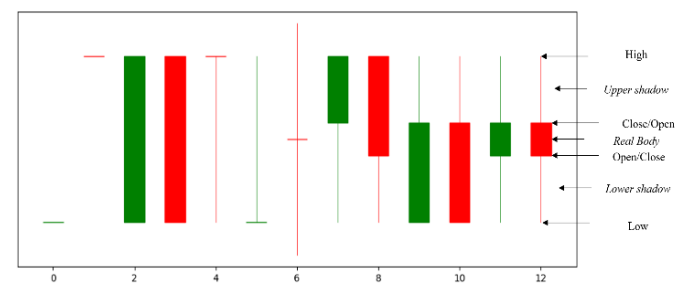

In [4]:
patterns = ['CDLCLOSINGMARUBOZU', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHIGHWAVE', 'CDLINVERTEDHAMMER', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLRICKSHAWMAN', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLTAKURI']
len(patterns)

16

In [5]:
def get_patterns(df):
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    # create columns for each pattern
    for candle in patterns:
        # below is same as;
        # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        df[candle] = getattr(talib, candle)(op, hi, lo, cl)
        
    return df

In [6]:
df = get_patterns(BTC)

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               3654 non-null   float64
 1   Open                3654 non-null   float64
 2   High                3654 non-null   float64
 3   Low                 3654 non-null   float64
 4   Volume              3654 non-null   float64
 5   Change              3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [8]:
df['CDLCLOSINGMARUBOZU'].unique()

array([   0, -100,  100])

# 기술적 모멘텀 지표

In [9]:
def get_indicators(df):
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    vo = df['Volume']
    
    df['ADX'] = talib.ADX(hi, lo, cl, timeperiod=14)
    df['APO'] = talib.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['BOP'] = talib.BOP(op, hi, lo, cl)
    df['CCI'] = talib.CCI(hi, lo, cl, timeperiod=14)
    df['DX'] = talib.DX(hi, lo, cl, timeperiod=14)
    df['MACD'], df['MACDSIGNAL'], df['MACDHIST'] = talib.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = talib.MFI(hi, lo, cl, vo, timeperiod=14)
    df['MOM'] = talib.MOM(cl, timeperiod=14)
    df['RSI'] = talib.RSI(cl, timeperiod=14)
    df['WILLR'] = talib.WILLR(hi, lo, cl, timeperiod=14)
    df['BOLUP'], _, df['BOLLOW'] = talib.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['EMA'] = talib.EMA(cl, timeperiod=50)
    
    return df

In [10]:
df = get_indicators(BTC)

In [11]:
plt.rcParams['figure.figsize'] = (20, 10)

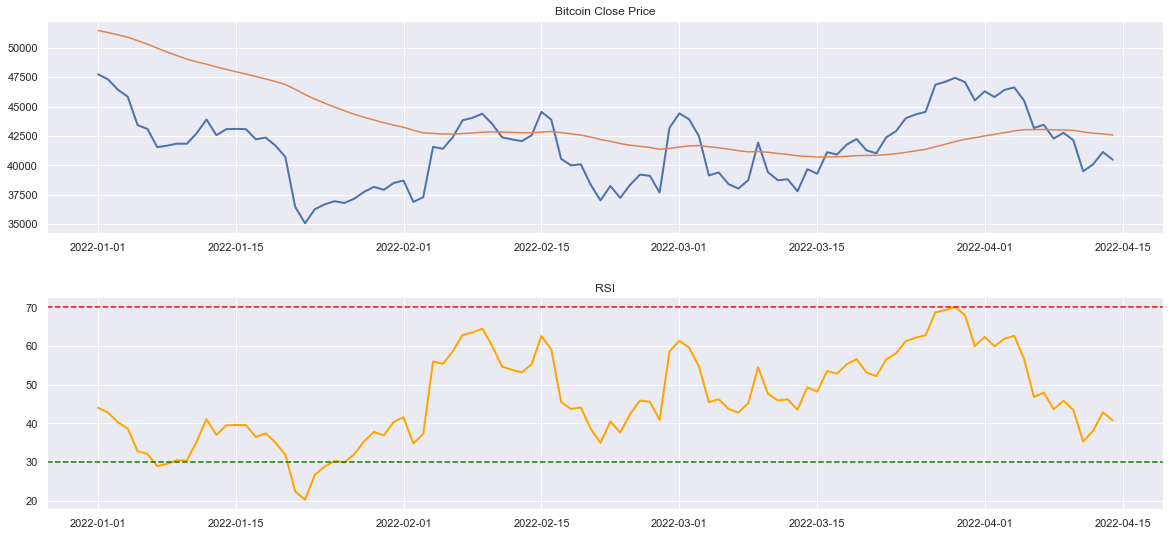

In [12]:
ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)

ax1.plot(df['2022']['Close'], linewidth=2)
ax1.plot(df['2022']['EMA'])
ax1.set_title('Bitcoin Close Price')

ax2.plot(df['2022']['RSI'], color='orange', linewidth=2)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'green')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'red')
ax2.set_title('RSI')
plt.show()

In [13]:
df.tail()

,Close,Open,High,Low,Volume,Change,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,MACD,MACDSIGNAL,MACDHIST,MFI,MOM,RSI,WILLR,BOLUP,BOLLOW,EMA
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-10,42138.0,42760.0,43421.0,41884.0,255830000.0,-0.0147,0,0,0,0,...,263.562739,882.393571,-618.830832,30.278836,-4721.0,43.496384,-95.977831,43766.607790,41753.792210,42977.155897
2022-04-11,39497.0,42144.0,42418.0,39202.0,608380000.0,-0.0627,0,0,0,0,...,-109.063993,684.102058,-793.166052,20.440014,-7608.0,35.305467,-96.694678,44714.467754,39335.532246,42840.679195
2022-04-12,40078.0,39507.0,40678.0,39265.0,468270000.0,0.0147,0,0,0,0,...,-353.417542,476.598138,-830.015680,12.498023,-7371.0,38.068484,-89.708647,43964.204317,38737.795683,42732.338834
2022-04-13,41133.0,40072.0,41515.0,39581.0,406700000.0,0.0263,0,0,0,0,...,-456.675535,289.943404,-746.618939,18.870910,-5942.0,42.842157,-77.071954,43567.015873,38678.184127,42669.619664
2022-04-14,40481.0,41133.0,41494.0,40340.0,341380000.0,-0.0159,0,0,0,0,...,-584.382789,115.078165,-699.460954,24.938967,-5044.0,40.751584,-84.464958,42483.399164,38847.400836,42583.791442


# 캔들스틱 8괘 분류
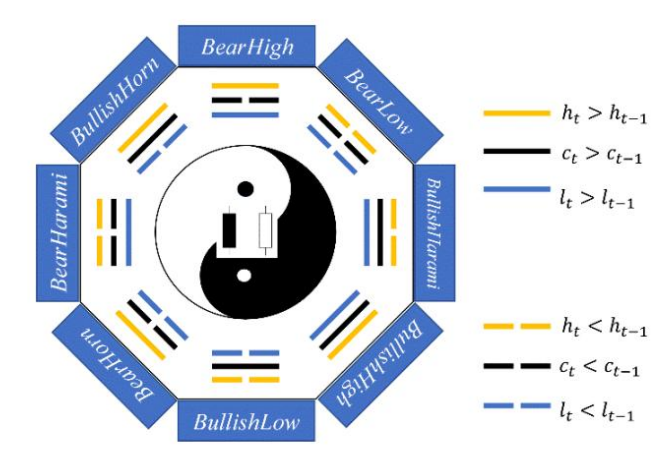

In [14]:
def eight_trigram(df):
    high_high = df['High'] >= df['High'].shift(1)
    high_low = df['High'] <= df['High'].shift(1)
    close_high = df['Close'] >= df['Close'].shift(1)
    close_low = df['Close'] <= df['Close'].shift(1)
    low_high = df['Low'] >= df['Low'].shift(1)
    low_low = df['Low'] <= df['Low'].shift(1)
    
    BearHorn = high_high & close_low & low_low
    BearHarami = high_low & close_low & low_high
    BearHigh = high_high & close_low & low_high
    BearLow = high_low & close_low & low_low
    BullishHorn = high_high & close_high & low_low
    BullishHarami = high_low & close_high & low_high
    BullishHigh = high_high & close_high & low_high
    BullishLow = high_low & close_high & low_low
    
    
    df['EightTri'] = 0
    df['EightTri'] = np.where(BearHorn, 1, df['EightTri'])
    df['EightTri'] = np.where(BearHarami, 2, df['EightTri'])
    df['EightTri'] = np.where(BearHigh, 3, df['EightTri'])
    df['EightTri'] = np.where(BearLow, 4, df['EightTri'])
    df['EightTri'] = np.where(BullishHorn, 5, df['EightTri'])
    df['EightTri'] = np.where(BullishHarami, 6, df['EightTri'])
    df['EightTri'] = np.where(BullishHigh, 7, df['EightTri'])
    df['EightTri'] = np.where(BullishLow, 8, df['EightTri'])
    

    df.loc[df.index[0], 'EightTri'] = random.randrange(1,8)
        
    return df

In [15]:
df = eight_trigram(BTC)

In [16]:
df['EightTri'].unique()

array([1, 7, 8, 4, 2, 3, 6, 5], dtype=int64)

In [17]:
df['Trend'] = 0
df['Trend'] = np.where(df['Close'] > df['EMA'], 1, 0)
df['Trend'].unique()

array([0, 1])

In [18]:
df.tail()

,Close,Open,High,Low,Volume,Change,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,MACDHIST,MFI,MOM,RSI,WILLR,BOLUP,BOLLOW,EMA,EightTri,Trend
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-10,42138.0,42760.0,43421.0,41884.0,255830000.0,-0.0147,0,0,0,0,...,-618.830832,30.278836,-4721.0,43.496384,-95.977831,43766.607790,41753.792210,42977.155897,1,0
2022-04-11,39497.0,42144.0,42418.0,39202.0,608380000.0,-0.0627,0,0,0,0,...,-793.166052,20.440014,-7608.0,35.305467,-96.694678,44714.467754,39335.532246,42840.679195,4,0
2022-04-12,40078.0,39507.0,40678.0,39265.0,468270000.0,0.0147,0,0,0,0,...,-830.015680,12.498023,-7371.0,38.068484,-89.708647,43964.204317,38737.795683,42732.338834,6,0
2022-04-13,41133.0,40072.0,41515.0,39581.0,406700000.0,0.0263,0,0,0,0,...,-746.618939,18.870910,-5942.0,42.842157,-77.071954,43567.015873,38678.184127,42669.619664,7,0
2022-04-14,40481.0,41133.0,41494.0,40340.0,341380000.0,-0.0159,0,0,0,0,...,-699.460954,24.938967,-5044.0,40.751584,-84.464958,42483.399164,38847.400836,42583.791442,2,0


# 시장데이터 병합

In [19]:
GOLD = pd.read_csv('./data/ZG.csv', parse_dates=['Date'], index_col = 'Date')
NDAQ = pd.read_csv('./data/IXIC.csv', parse_dates=['Date'], index_col = 'Date')
US10YT = pd.read_csv('./data/US10YT.csv', parse_dates=['Date'], index_col = 'Date')
VIX = pd.read_csv('./data/VIX.csv', parse_dates=['Date'], index_col = 'Date')

In [20]:
t1 = BTC.merge(GOLD, on='Date', how='left', suffixes=('_BTC', '_GLD'))

In [21]:
t1 = BTC.merge(GOLD, on='Date', how='left', suffixes=('_BTC', '_GLD'))
list_df = ['NDAQ', 'US10YT', 'VIX']
for x in list_df:
    t1 = t1.merge(globals()[x].add_suffix('_'+str(x)),
                 on='Date', how='left')
t1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3654 non-null   float64
 1   Open_BTC            3654 non-null   float64
 2   High_BTC            3654 non-null   float64
 3   Low_BTC             3654 non-null   float64
 4   Volume_BTC          3654 non-null   float64
 5   Change_BTC          3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [22]:
t1.Volume_GLD.fillna(0, inplace=True)
t1.Change_GLD.fillna(0, inplace=True)
t1.Volume_NDAQ.fillna(0, inplace=True)
t1.Change_NDAQ.fillna(0, inplace=True)
t1.Change_US10YT.fillna(0, inplace=True)
t1.Volume_VIX.fillna(0, inplace=True)
t1.Change_VIX.fillna(0, inplace=True)

In [23]:
df = t1.fillna(0)
df.dropna(inplace=True)
df.isna().sum()

Close_BTC     0
Open_BTC      0
High_BTC      0
Low_BTC       0
Volume_BTC    0
             ..
Open_VIX      0
High_VIX      0
Low_VIX       0
Volume_VIX    0
Change_VIX    0
Length: 62, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3654 non-null   float64
 1   Open_BTC            3654 non-null   float64
 2   High_BTC            3654 non-null   float64
 3   Low_BTC             3654 non-null   float64
 4   Volume_BTC          3654 non-null   float64
 5   Change_BTC          3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [25]:
df['target'] = df['Close_BTC'].pct_change()
df['target'] = np.where(df['target'] > 0 , 1, -1)
df['target'] = df['target'].shift(-1)
df = df.dropna()

In [26]:
y_var = df['target']
x_var = df.drop(['target', 'Volume_VIX'], axis=1) 
x_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2012-04-13 to 2022-04-13
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3653 non-null   float64
 1   Open_BTC            3653 non-null   float64
 2   High_BTC            3653 non-null   float64
 3   Low_BTC             3653 non-null   float64
 4   Volume_BTC          3653 non-null   float64
 5   Change_BTC          3653 non-null   float64
 6   CDLCLOSINGMARUBOZU  3653 non-null   int32  
 7   CDLDOJI             3653 non-null   int32  
 8   CDLDRAGONFLYDOJI    3653 non-null   int32  
 9   CDLGRAVESTONEDOJI   3653 non-null   int32  
 10  CDLHAMMER           3653 non-null   int32  
 11  CDLHANGINGMAN       3653 non-null   int32  
 12  CDLHIGHWAVE         3653 non-null   int32  
 13  CDLINVERTEDHAMMER   3653 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3653 non-null   int32  
 15  CDLLONGLINE         3653 non-null   i

In [27]:
up=df[df['target']==1].target.count()
total=df.target.count()
print('up/down ratio: {0:.2f}'.format((up/total)))

up/down ratio: 0.53


In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_var, 
                                                    y_var, 
                                                    test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=3)

train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
 1.0    0.523614
-1.0    0.476386
Name: target, dtype: float64
test set label ratio
 1.0    0.53762
-1.0    0.46238
Name: target, dtype: float64


In [29]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

In [30]:
n_estimators = range(10,400,10)

xg_parameters ={'max_depth' : [3,4,5,6],
                'objective':['binary:logistic'],
                'n_estimators': n_estimators, 
                'learning_rate':[0.01, 0.1], 
                'gamma': [0.5, 1, 2], 
                'random_state':[3],
               'early_stopping_rounds':[30],
               'eval_metric' : ['logloss'], 
                'eval_set' : [[X_test, y_test]],
               'scoring':['f1']}

# xgb_cv = TimeSeriesSplit(n_splits=5).split(X_train)
xgb_cv=KFold(n_splits=5)

In [31]:
# xgb_dis = XGBClassifier(eval_metric='error', n_estimators=400, learning_rate=0.1, max_depth=3, random_state=3, early_stopping_rounds=30)
xgb_model = XGBClassifier()

xgb_clf = GridSearchCV(xgb_model, xg_parameters, n_jobs=-1, 
                       cv=xgb_cv,
                       verbose=1
#                        , n_folds=5, shuffle=True, 
#                    scoring='roc_auc',
                      )

# xgb_dis.fit(X_train, y_train)
# xgb_pred = xgb_dis.predict(X_test)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

Fitting 5 folds for each of 936 candidates, totalling 4680 fits
[15:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set", "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [33]:
print("xgb best params : ", xgb_clf.best_params_)
print(get_confusion_matrix(y_test, xgb_pred))

xgb best params :  {'early_stopping_rounds': 30, 'eval_metric': 'logloss', 'eval_set': [            Close_BTC  Open_BTC  High_BTC  Low_BTC   Volume_BTC  Change_BTC  \
Date                                                                          
2020-04-13     6841.3    6918.1    6920.3   6618.5    1250000.0     -0.0110   
2020-04-14     6850.9    6841.8    6970.8   6768.6     999530.0      0.0014   
2020-04-15     6629.1    6851.3    6929.5   6615.9    1000000.0     -0.0324   
2020-04-16     7085.6    6629.1    7159.7   6520.5    1540000.0      0.0689   
2020-04-17     7035.8    7085.5    7142.8   7005.8     810100.0     -0.0070   
...               ...       ...       ...      ...          ...         ...   
2022-04-09    42767.0   42275.0   42809.0  42129.0  165160000.0      0.0116   
2022-04-10    42138.0   42760.0   43421.0  41884.0  255830000.0     -0.0147   
2022-04-11    39497.0   42144.0   42418.0  39202.0  608380000.0     -0.0627   
2022-04-12    40078.0   39507.0   40678.0  

In [37]:
corr = df.corr()
corr.apply(lambda x: round(x ,2))
corr

,Close_BTC,Open_BTC,High_BTC,Low_BTC,Volume_BTC,Change_BTC,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,High_US10YT,Low_US10YT,Change_US10YT,Close_VIX,Open_VIX,High_VIX,Low_VIX,Volume_VIX,Change_VIX,target
Close_BTC,1.000000,0.998961,0.999549,0.999440,0.159508,-0.009847,0.013333,-0.032594,-0.027632,0.003916,...,-0.172446,-0.179774,0.031234,0.124555,0.127448,0.128894,0.124335,NaN,-0.000007,-0.020259
Open_BTC,0.998961,1.000000,0.999566,0.999183,0.159686,-0.023562,0.000464,-0.032275,-0.027542,0.003946,...,-0.171582,-0.178934,0.029424,0.124660,0.126565,0.128741,0.123857,NaN,0.006682,-0.018675
High_BTC,0.999549,0.999566,1.000000,0.999115,0.159811,-0.016264,0.006376,-0.034410,-0.028892,0.003889,...,-0.171082,-0.178487,0.030611,0.126719,0.128970,0.130939,0.126005,NaN,0.004725,-0.019301
Low_BTC,0.999440,0.999183,0.999115,1.000000,0.160501,-0.015167,0.005614,-0.029764,-0.027132,0.006062,...,-0.173223,-0.180522,0.030000,0.122357,0.124814,0.126384,0.121969,NaN,0.002007,-0.020035
Volume_BTC,0.159508,0.159686,0.159811,0.160501,1.000000,-0.003474,-0.014589,-0.017647,0.003781,0.004323,...,0.022460,0.018359,0.036472,0.092058,0.097597,0.091843,0.096043,NaN,-0.019130,0.002066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
High_VIX,0.128894,0.128741,0.130939,0.126384,0.091843,0.008668,0.019989,-0.062842,-0.031554,-0.022711,...,0.274706,0.249719,0.053899,0.995888,0.993134,1.000000,0.991584,NaN,0.068746,0.005689
Low_VIX,0.124335,0.123857,0.126005,0.121969,0.096043,0.012078,0.024957,-0.060531,-0.032977,-0.022822,...,0.289460,0.265699,0.052784,0.993511,0.996068,0.991584,1.000000,NaN,0.030061,0.005072
Volume_VIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Change_VIX,-0.000007,0.006682,0.004725,0.002007,-0.019130,-0.032237,-0.032511,-0.033887,0.001157,-0.008452,...,0.015588,0.011868,-0.232440,0.102547,-0.001498,0.068746,0.030061,NaN,1.000000,0.025974


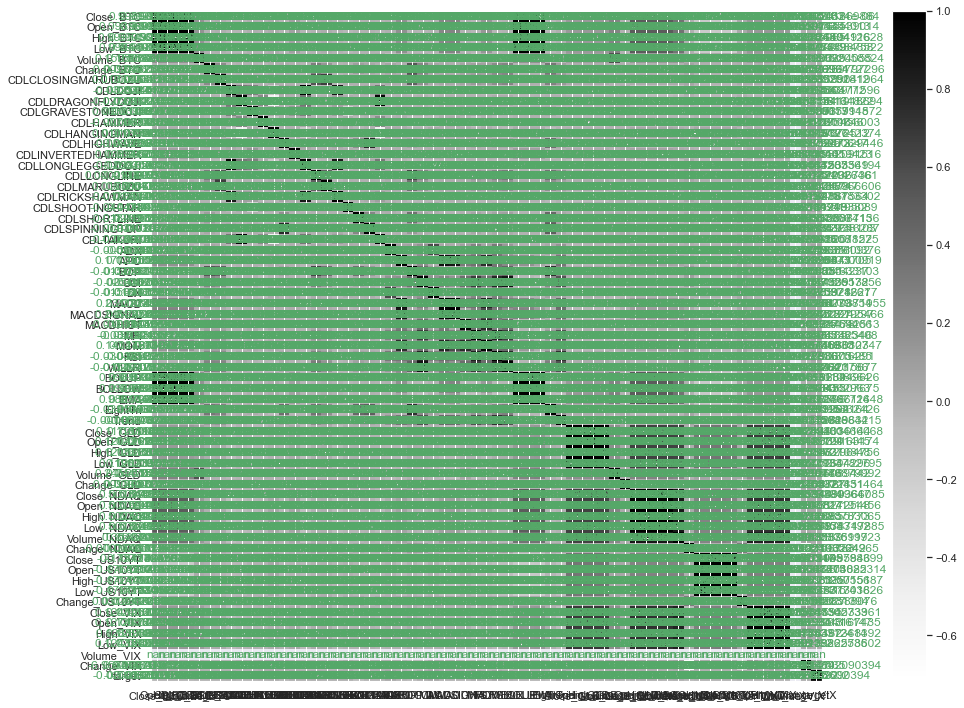

In [39]:
fig, ax = plt.subplots()
im = ax.imshow(corr, cmap='Greys')

# Color Bar
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))

ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

for x in range(len(corr.columns)):
    for y in range(len(corr.index)):
        ax.text(y, x, corr.iloc[y, x], ha='center', va='center', color='g')

fig.tight_layout()   
plt.show()    

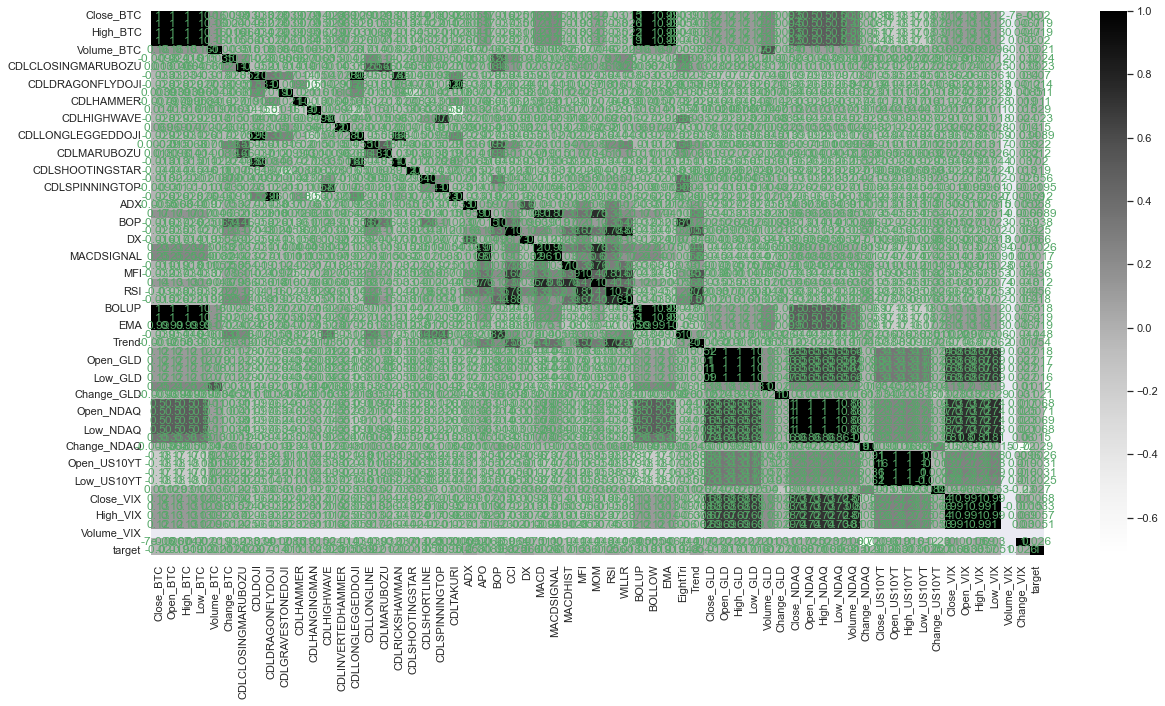

In [40]:
ax = sns.heatmap(corr, annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

In [34]:
get_confusion_matrix(y_test, xgb_pred)

confusion matrix
accuracy:0.5472,precision:0.5613,recall:0.7226,F1:0.6318,ROC AUC score:0.5329


In [ ]:
xgb_dis

In [ ]:
print(xgb_dis.score(X_train, y_train))

In [33]:
n_estimators = range(10,200,10)

params = {
    'bootstrap': [True],
    'n_estimators':n_estimators,
    'max_depth':[4,6,8,10,12],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_features':[4]
}

In [34]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

In [35]:
my_cv

<generator object TimeSeriesSplit.split at 0x00000207E41E0EB0>

In [36]:
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)

In [37]:
clf

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000207E41E0EB0>,
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 6, 8, 10, 12],
                         'max_features': [4], 'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': range(10, 200, 10)})

In [38]:
import time

In [39]:
start_time = time.time()
clf.fit(X_train, y_train)
print(time.time() - start_time," seconds consumed")

260.3146436214447  seconds consumed


In [40]:
## Random Forest에서 best param
print('best parameter:\n', clf.best_params_)
print('best prediction:{0:.4f}'.format(clf.best_score_))

best parameter:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 20}
best prediction:0.5355


In [41]:
lgb = LGBMClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, random_state=3)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

In [42]:
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('RF accuracy:{0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

print("xgb score :", xgb_dis.score(X_train, y_train))
get_confusion_matrix(y_test, xgb_pred)

print("lgb score :", lgb.score(X_train, y_train))
get_confusion_matrix(y_test, lgb_pred)

RF accuracy:0.4815
confusion matrix
accuracy:0.4815,precision:0.5946,recall:0.1120,F1:0.1884,ROC AUC score:0.5116
xgb score : 0.9065708418891171
confusion matrix
accuracy:0.4925,precision:0.6618,recall:0.1145,F1:0.1952,ROC AUC score:0.5232
lgb score : 0.8952772073921971
confusion matrix
accuracy:0.4938,precision:0.6237,recall:0.1476,F1:0.2387,ROC AUC score:0.5220
